## Filter and store objective optimization goal data

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
# import tensorflow_probability as tfp
# import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
from mining.modules.budget.optimization import rwAdsDataFile as file

''' restart initiate classes '''
if debug:
    import importlib
    file=importlib.reload(file)

__desc__ = "read and write dataset for MCMC sampling"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
print("\n%s class initialization and load complete!" % __desc__)

All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional RWADSDATA-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete

read and write dataset for MCMC sampling class initialization and load complete!


## Load Data

In [3]:
_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"

__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

kwargs = {
    "REALMFILTATTR" : 'objective',
    "REALMFILTLIST" : [__def_obj__],
    "UNIXTIMESTAMP" : __def_date_attr__,
}
sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    **kwargs,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()


25/03/04 21:13:08 WARN Utils: Your hostname, FarmRaider2 resolves to a loopback address: 127.0.1.1; using 192.168.2.85 instead (on interface enp3s0)
25/03/04 21:13:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/04 21:13:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/04 21:13:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/04 21:14:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

[Error]rwAdsData function <read_realm> name 'obj_sdf' is not defined


[Stage 419:=============================================>           (4 + 1) / 5]

Loaded FullDataset.csv 58280 rows


## Filter by optimization goal

In [6]:
__def_obj_col__ = 'objective'
__def_opt_goal__= 'purchase'  # action group
__def_dt_cols__ = [f"unix_{__def_date_attr__}", __def_date_attr__]
__def_ad_met_cols__ = ['spend','impressions', 'clicks', 'reach', 
                       'frequency', 'CTR', 'CPP', 'CPC', 'CPM']
__def_roas_cols__ = ['purchase_value', 'purchase_roas']

_goal_act_cols = [x for x in sdf.columns
                  if x.find(__def_opt_goal__)==0
                  and x not in [*__def_ad_met_cols__, 
                                *__def_dt_cols__,
                                *__def_roas_cols__]]

''' Remove goal action cols not greater than zero '''
count_dict= {}
for act  in _goal_act_cols:
    count_dict[act]=sdf.select(act).dropna().count()

_act_met_cols_lst = [k for k,v in count_dict.items() if v>0]
_act_met_cols_lst

''' select data for relevant columns '''
_obj_goal_sdf=sdf.select(*__def_dt_cols__, __def_obj_col__,
                         *__def_roas_cols__, *__def_ad_met_cols__,
                         *_act_met_cols_lst)\
                .orderBy(*__def_dt_cols__)

_obj_goal_sdf.printSchema()

[Stage 450:=============================================>           (4 + 1) / 5]

root
 |-- unix_updated_time: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- objective: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- purchase_roas: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- reach: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- purchase_onsite_conversion__purchase: double (nullable = true)
 |-- purchase_offsite_conversion__fb_pixel_purchase: double (nullable = true)
 |-- purchase_app_custom_event__fb_mobile_purchase: double (nullable = true)
 |-- purchase_omni_purchase: double (nullable = true)



## Write objective & goal data to file

In [7]:
__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

_fpath = "mining/data/budget/optimization/objective"
_fname = "_".join([__def_obj__.lower(),__def_opt_goal__.lower()])
_fname +=".csv"

write_data = clsFile.write_realm(
    realm=__def_realm__,
    data =_obj_goal_sdf,
    fname=_fname,
    fpath=_fpath,
)
print("saved %d data rows to %s" 
      %(_obj_goal_sdf.count(), write_data.upper()))

[Stage 460:=============================================>           (4 + 1) / 5]

saved 58280 data rows to /HOME/NUWAN/WORKSPACE/MADGICX/MINING/DATA/BUDGET/OPTIMIZATION/OBJECTIVE/OUTCOME_LEADS_PURCHASE.CSV


In [9]:
_plot_df = _obj_goal_sdf.groupBy(f"unix_{__def_date_attr__}")\
                        .sum(*_act_met_cols_lst)\
                        .orderBy(f"unix_{__def_date_attr__}").toPandas()

for col in _act_met_cols_lst:
    _plot_df.rename(columns={f"sum({col})" : col}, inplace=True)
    _plot_df[col].fillna(0, inplace=True)
_plot_df

,unix_updated_time,purchase_onsite_conversion__purchase,purchase_offsite_conversion__fb_pixel_purchase,purchase_app_custom_event__fb_mobile_purchase,purchase_omni_purchase
0,1737475200,0.0,2.107234e+05,0.00,2.107234e+05
1,1737561600,0.0,1.145264e+09,4495.34,1.149758e+09
2,1737648000,0.0,4.060610e+05,0.00,4.283020e+05
3,1737734400,0.0,1.325107e+05,0.00,1.325377e+05
4,1737820800,0.0,4.243986e+05,0.00,4.276746e+05
5,1737907200,0.0,4.100523e+05,0.00,4.209203e+05
6,1737993600,6003926.0,3.087635e+05,5086.71,1.073797e+08
7,1738080000,6881.0,1.861053e+05,0.00,1.896239e+05
8,1738166400,0.0,8.612550e+05,0.00,5.561255e+06
9,1738252800,0.0,3.465395e+05,383.80,2.888809e+07


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
scaled_arr = scaler.fit_transform(_plot_df[_act_met_cols_lst])
scaled_arr

array([[0.00000000e+00, 4.66704127e-05, 0.00000000e+00, 4.66704035e-05],
       [0.00000000e+00, 2.53649767e-01, 8.83742144e-01, 2.54645145e-01],
       [0.00000000e+00, 8.99332138e-05, 0.00000000e+00, 9.48590677e-05],
       [0.00000000e+00, 2.93480822e-05, 0.00000000e+00, 2.93540562e-05],
       [0.00000000e+00, 9.39945905e-05, 0.00000000e+00, 9.47201307e-05],
       [0.00000000e+00, 9.08172021e-05, 0.00000000e+00, 9.32241970e-05],
       [1.00000000e+00, 6.83840433e-05, 1.00000000e+00, 2.37821463e-02],
       [1.14608341e-03, 4.12180734e-05, 0.00000000e+00, 4.19973522e-05],
       [0.00000000e+00, 1.90748281e-04, 0.00000000e+00, 1.23169052e-03],
       [0.00000000e+00, 7.67505676e-05, 7.54515197e-02, 6.39805076e-03],
       [0.00000000e+00, 4.66706121e-06, 0.00000000e+00, 1.00660071e-05],
       [0.00000000e+00, 4.09030593e-01, 0.00000000e+00, 4.09030553e-01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.33595917e-03, 1.49999893e-03, 0.00000000e

In [18]:
scaled_arr=np.array(_plot_df[_act_met_cols_lst])
scaled_arr

array([[4.67780930e+05, 2.74321082e+06, 9.08055000e+03],
       [2.13000527e+06, 1.15590020e+09, 1.09220700e+04],
       [1.07824862e+06, 3.55834860e+05, 6.38167000e+04],
       [2.84242260e+05, 2.43165380e+05, 2.81800000e+01],
       [2.93562660e+05, 1.52063300e+05, 3.62890000e+02],
       [3.10948290e+05, 1.04756610e+06, 4.80004000e+03],
       [4.91999716e+11, 5.12470740e+05, 2.99414900e+04],
       [3.41225440e+05, 2.75761570e+05, 4.71354000e+03],
       [5.31117260e+05, 1.90831499e+07, 1.45989400e+04],
       [2.62150866e+06, 6.02624830e+05, 1.05506730e+05],
       [4.59861190e+05, 1.58552450e+05, 4.95974000e+03],
       [1.74222600e+05, 1.84686323e+09, 1.00697000e+03],
       [4.31918547e+06, 4.52704632e+09, 2.72413350e+05],
       [1.02377835e+06, 7.31176331e+06, 1.00580300e+04],
       [6.01421218e+06, 6.44996074e+06, 5.76821820e+05],
       [3.34736500e+04, 1.30084260e+05, 1.53716300e+04],
       [1.35392556e+06, 1.02832114e+06, 9.21570000e+03],
       [5.15544700e+04, 4.16940

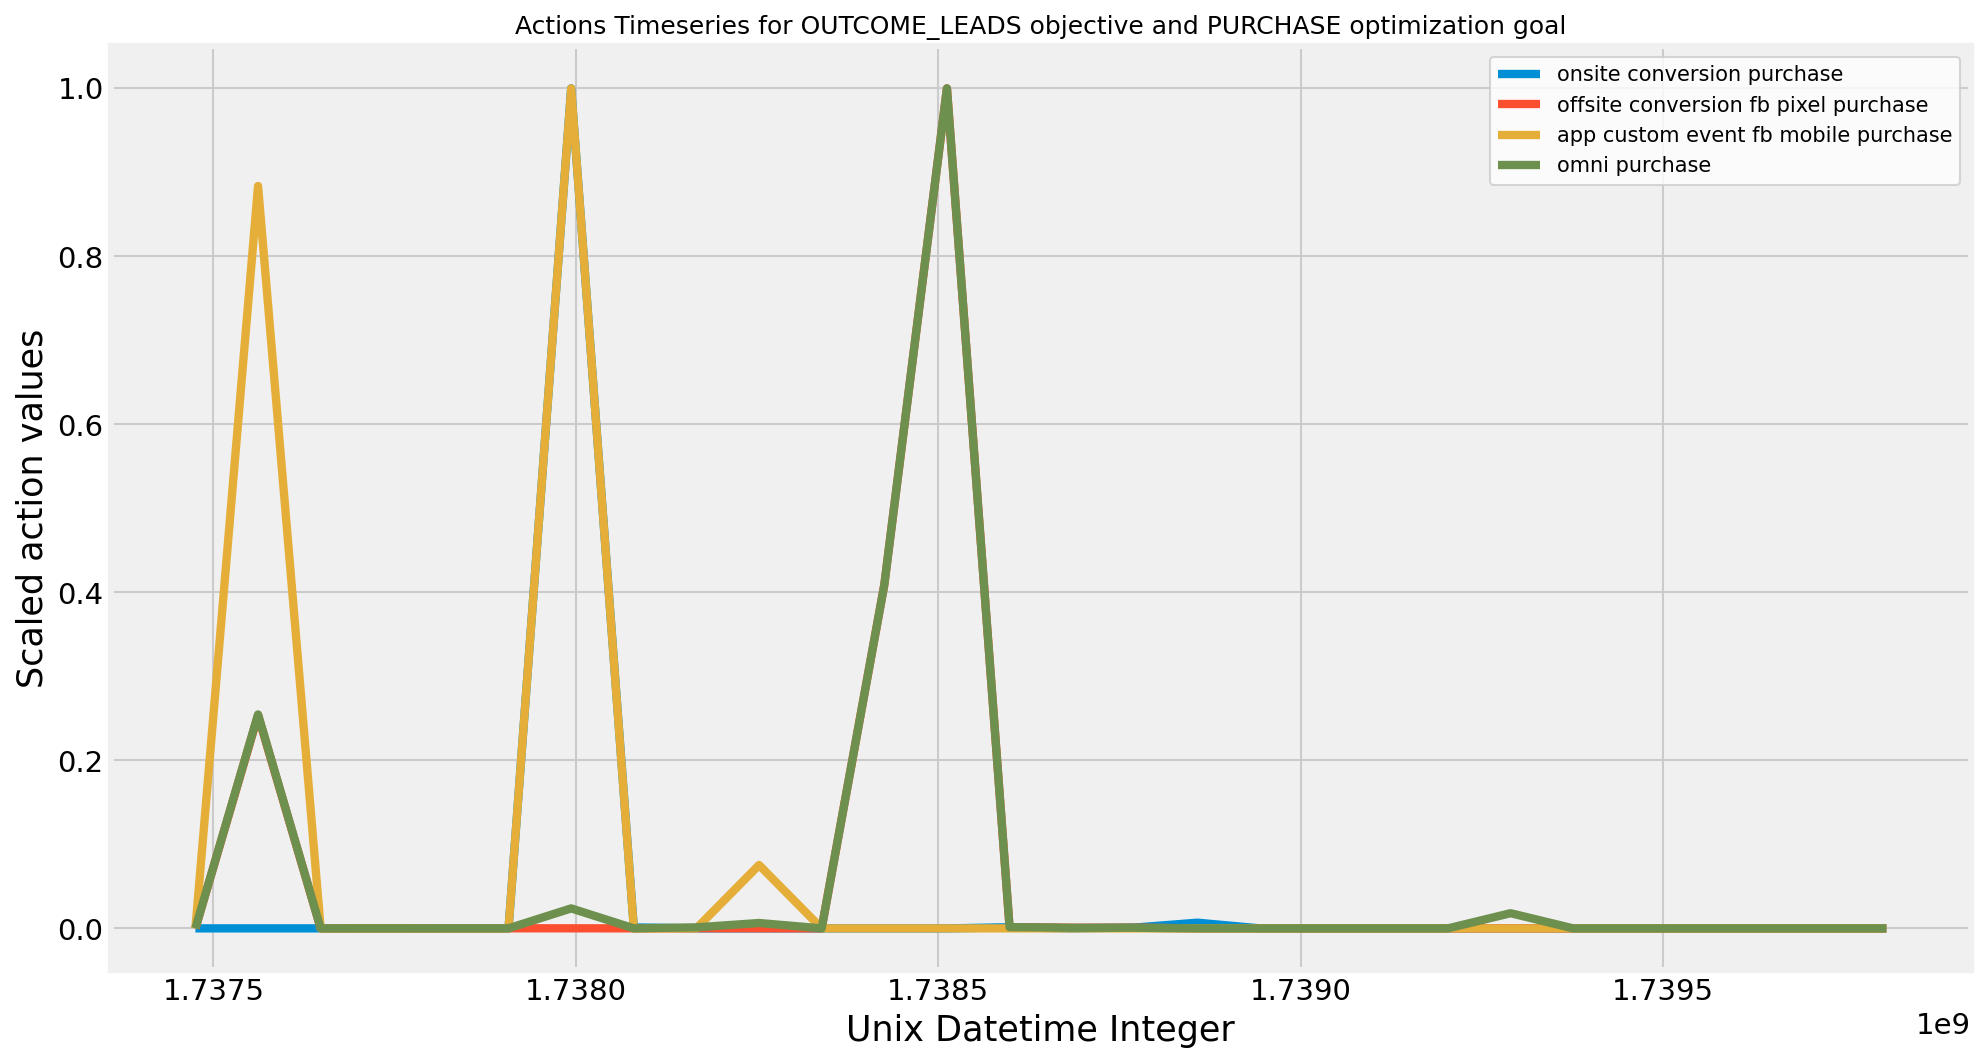

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8), dpi=150) 
with plt.style.context('fivethirtyeight'):
    for i in range(0,scaled_arr.shape[1],1):
        plt.plot(_plot_df[f"unix_{__def_date_attr__}"], scaled_arr[:,i])

plt.title(f"Actions Timeseries for {__def_obj__} objective and {__def_opt_goal__.upper()}"+\
          " optimization goal")
plt.xlabel('Unix Datetime Integer')
plt.ylabel('Scaled action values')
leg = [x.replace('__'," ").replace("_"," ").split(' ', 1)[1] for x in _act_met_cols_lst]
plt.legend(leg, loc="upper right")
plt.show()

## Fit with Normal distribution

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters
    alpha_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpc")
    beta_cpc = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpc")

    alpha_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha_roas")
    beta_roas = yield tfd.Normal(loc=0.0, scale=1.0, name="beta_roas")
    
    # Likelihoods
    cpc_pred = yield tfd.Normal(loc=alpha_cpc + beta_cpc * spend_scaled, scale=0.1, name="cpc_pred")
    cpm_pred = yield tfd.Normal(loc=alpha_cpm + beta_cpm * spend_scaled, scale=0.1, name="cpm_pred")
    ctr_pred = yield tfd.Normal(loc=alpha_ctr + beta_ctr * spend_scaled, scale=0.01, name="ctr_pred")
    roas_pred = yield tfd.Normal(loc=alpha_roas + beta_roas * spend_scaled, scale=0.1, name="roas_pred")

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 10000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(0.5),  # alpha_cpc
    tf.constant(0.1),  # beta_cpc
    tf.constant(10.0),  # alpha_cpm
    tf.constant(0.1),  # beta_cpm
    tf.constant(0.02),  # alpha_ctr
    tf.constant(0.01),  # beta_ctr
    tf.constant(4.0),  # alpha_roas
    tf.constant(0.1),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print("Completed generating samples")

## Fit with Gamma distribution

In [69]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

# Example historic data (replace with your actual data)
# Each row represents a historic data point: [Spend, CPC, CPM, CTR, ROAS]
# historic_data = np.array([
#     [100, 0.5, 10, 0.02, 4.0],
#     [200, 0.6, 12, 0.03, 3.5],
#     [300, 0.7, 15, 0.04, 3.0],
#     # Add more data points here
# ])
historic_data = np.array(_data_df)

# Split the data into input (Spend) and outputs (CPC, CPM, CTR, ROAS)
spend = historic_data[:, 0].astype(np.float32)  # Ensure float32 for TensorFlow
cpc = historic_data[:, 1].astype(np.float32)
cpm = historic_data[:, 2].astype(np.float32)
ctr = historic_data[:, 3].astype(np.float32)
roas = historic_data[:, 4].astype(np.float32)

# Scale the Spend data to improve numerical stability
spend_mean = np.mean(spend)
spend_std = np.std(spend)
spend_scaled = (spend - spend_mean) / spend_std

# Define the probabilistic model
def model():
    # Priors for the parameters (using Gamma distributions for non-negativity)
    alpha_cpc = yield tfd.Gamma(
        concentration=1.0, 
        rate=1.0, 
        name="alpha_cpc")
    beta_cpc = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpc")
    
    alpha_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_cpm")
    beta_cpm = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_cpm")
    
    alpha_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_ctr")
    beta_ctr = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_ctr")
    
    alpha_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="alpha_roas")
    beta_roas = yield tfd.Gamma(concentration=1.0, rate=1.0, name="beta_roas")
    
    # Likelihoods (using Gamma distributions for non-negativity)
    cpc_pred = yield tfd.Gamma(
        concentration=alpha_cpc + beta_cpc * spend_scaled,
        rate=1.0,
        name="cpc_pred"
    )
    cpm_pred = yield tfd.Gamma(
        concentration=alpha_cpm + beta_cpm * spend_scaled,
        rate=1.0,
        name="cpm_pred"
    )
    ctr_pred = yield tfd.Gamma(
        concentration=alpha_ctr + beta_ctr * spend_scaled,
        rate=1.0,
        name="ctr_pred"
    )
    roas_pred = yield tfd.Gamma(
        concentration=alpha_roas + beta_roas * spend_scaled,
        rate=1.0,
        name="roas_pred"
    )

# Define the joint distribution
joint_distribution = tfd.JointDistributionCoroutineAutoBatched(model)

# Define the log probability function
def log_prob(alpha_cpc, beta_cpc, alpha_cpm, beta_cpm, alpha_ctr, beta_ctr, alpha_roas, beta_roas):
    return joint_distribution.log_prob(
        alpha_cpc=alpha_cpc,
        beta_cpc=beta_cpc,
        alpha_cpm=alpha_cpm,
        beta_cpm=beta_cpm,
        alpha_ctr=alpha_ctr,
        beta_ctr=beta_ctr,
        alpha_roas=alpha_roas,
        beta_roas=beta_roas,
        cpc_pred=cpc,
        cpm_pred=cpm,
        ctr_pred=ctr,
        roas_pred=roas,
    )

# Use MCMC to sample from the posterior
num_results = 2000  # Increase the number of samples
num_burnin_steps = 1000  # Increase the burn-in steps

# Initialize the chain with reasonable values
initial_chain_state = [
    tf.constant(1.0),  # alpha_cpc
    tf.constant(1.0),  # beta_cpc
    tf.constant(1.0),  # alpha_cpm
    tf.constant(1.0),  # beta_cpm
    tf.constant(1.0),  # alpha_ctr
    tf.constant(1.0),  # beta_ctr
    tf.constant(1.0),  # alpha_roas
    tf.constant(1.0),  # beta_roas
]

# Define the MCMC kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=10,
    step_size=0.05,  # Adjusted step size
)

# Run the MCMC sampler
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel=hmc_kernel,
        trace_fn=None,
    )

# Run the chain and get samples
samples = run_chain()

# Extract the posterior samples
alpha_cpc_samples, beta_cpc_samples, alpha_cpm_samples, beta_cpm_samples, \
alpha_ctr_samples, beta_ctr_samples, alpha_roas_samples, beta_roas_samples = samples

print('Completed generating Gama distribution data')


## Predict Performance for Spend Value

In [70]:
# Predict expected values for a given Spend
def predict(spend_value):
    # Scale the input Spend value
    spend_value_scaled = (spend_value - spend_mean) / spend_std
    
    # Compute predictions
    # cpc_pred = np.mean(alpha_cpc_samples + beta_cpc_samples * spend_value_scaled)
    # cpm_pred = np.mean(alpha_cpm_samples + beta_cpm_samples * spend_value_scaled)
    # ctr_pred = np.mean(alpha_ctr_samples + beta_ctr_samples * spend_value_scaled)
    # roas_pred = np.mean(alpha_roas_samples + beta_roas_samples * spend_value_scaled)
    cpc_pred = alpha_cpc_samples + beta_cpc_samples * spend_value_scaled
    cpm_pred = alpha_cpm_samples + beta_cpm_samples * spend_value_scaled
    ctr_pred = alpha_ctr_samples + beta_ctr_samples * spend_value_scaled
    roas_pred = alpha_roas_samples + beta_roas_samples * spend_value_scaled
    
    return cpc_pred, cpm_pred, ctr_pred, roas_pred

# Example prediction for a given Spend
spend_value = 72.56  # Replace with your desired Spend value
cpc_pred, cpm_pred, ctr_pred, roas_pred = predict(spend_value)

print(f"Expected CPC for Spend={spend_value}: {np.mean(cpc_pred)}")
print(f"Expected CPM for Spend={spend_value}: {np.mean(cpm_pred)}")
print(f"Expected CTR for Spend={spend_value}: {np.mean(ctr_pred)}")
print(f"Expected ROAS for Spend={spend_value}: {np.mean(roas_pred)}")

Expected CPC for Spend=72.56: 0.7994794249534607
Expected CPM for Spend=72.56: 0.7994794249534607
Expected CTR for Spend=72.56: 0.7994794249534607
Expected ROAS for Spend=72.56: 0.7994794249534607


In [ ]:
643.58975     4.068199    83.871559     3.038284     3.730636

In [43]:
_data_df[_data_df['spend_usd']<91]

,spend_usd,CPC,CPM,CTR,ROAS,click,impressions,frequency,reach
0,6.44,0.920000,11.398230,1.238938,18.636646,7,565,1.134538,498
1,5.00,1.000000,13.227513,1.322751,18.190000,5,378,1.192429,317
2,25.84,1.845714,29.397042,1.592719,9.854876,14,879,1.153543,762
3,16.29,1.086000,10.745383,0.989446,5.831799,15,1516,1.179767,1285
4,63.54,1.245882,55.933099,4.489437,8.462386,51,1136,1.347568,843
...,...,...,...,...,...,...,...,...,...
5397,72.56,0.980541,48.373333,4.933333,0.663589,74,1500,1.255230,1195
5398,49.69,1.014082,41.134106,4.056291,5.895150,49,1208,1.391705,868
5401,36.70,0.965789,34.819734,3.605313,3.442234,38,1054,1.299630,811
5406,19.59,0.932857,36.892655,3.954802,7.918836,21,531,1.149351,462
